# Most advanced version of thesis so far.

In [16]:
import numpy as np
import numpy.core.records as rec
import pandas as pd
from astropy.io import ascii, fits
from astropy.table import Table, vstack, unique, Column, join
import os
import glob
import matplotlib.pyplot as plt
from scipy import constants as const

rangeinfimum = 3.5855                             #We're choosing the minimum log_10 value
rangesupremum = 3.9494                            #This is the maximum log_10 value

def firstrun(numbertorun):                        #Obtains the spectra and writes it to file.
    speclist = open('testfile.txt','r+')
    count=0
    
    with open('C:\\Users\\Filip\\Jupyter\\specs\\textfile.txt', 'w') as speca:
        for line in speclist:                             
            if count < numbertorun:
                speca.write('D:\\spectradata\\'+line)
                count+=1
    speclist.close()
    speca.close()

def secondrun(numbertorun,prune):               #Obtains the spectra and writes it to file. Eliminates unwanted spectra
    speclist = open('testfile.txt','r+')
    a = 0
    count = 0
    pulledlines = []

    with open('C:\\Users\\Filip\\Jupyter\\specs\\textfile.txt', 'w') as speca:
        for line in speclist:
            if a < numbertorun:   
                if count != len(prune) and a == prune[count]:
                    pulledlines.append(line)
                    a+=1
                    count+=1
                else:
                    speca.write('D:\\spectradata\\'+line)
                    a = a+1
    speclist.close()
    speca.close()

def prunefn():                                       #We are defining the lists of wavelengths that don't match the
    prune = []                                       #requirements to be able to run through our code.
    lengths = []
    infimum = []
    supremum = []
    spec_list = []
    loglamdata = []
    speclist = ascii.read('C:\\Users\\Filip\\Jupyter\\specs\\textfile.txt',format='no_header')
    for i in range(0,len(speclist)):
        spec_list.append(np.array(fits.getdata(speclist[i][0],1)['flux']))
        loglamdata.append(np.array(fits.getdata(speclist[i][0],1)['loglam']))

    for i in range(0,len(loglamdata)):
        infimum.append(loglamdata[i][0])                            #List of all the first numbers
        lengths.append(len(loglamdata[i]))                          #Obviously the lengths
        supremum.append(loglamdata[i].max())   
    
    print('############################################################')
    print("Our troublesome infimum values are:")
    print('Smallest Value     Star Number     Length')
    supremumcounter = 0
    infimumcounter = 0
    for count in range(0,len(supremum)):
        if infimum[count] > rangeinfimum:
            supremumcounter+=1
            print('%1.4f                   %5.0f       %4.0f' %(infimum[count],count,lengths[count]))
            prune.append(count)
    print('############################################################')
    print("Our troublesome supremum values are:")
    print('Largest Value      Star Number     Length')
    for count in range(0,len(supremum)):
        if supremum[count] < rangesupremum:
            infimumcounter+=1
            print('%1.4f                  %5.0i       %4.0f' %(supremum[count], count, lengths[count]))
            prune.append(count)
    print('############################################################')
    print('If we use this range we are left with', int(10000*(rangesupremum-rangeinfimum)+1))
    print('\nSupremum Count = ', supremumcounter)
    print('Infimum Count = ', infimumcounter)
    prune = np.sort(prune)
    return (prune,infimum,supremum,loglamdata,lengths,spec_list)

def truncation(infimum,supremum,loglamdata,lengths,spec_list,subclass):        #We are removing the values and returning a 
    new_wavelength = []                                                        #dataset that is a perfect block.
    new_flux = []
    topcut = []
    bottomcut = []
    bottomcutter = []
    fluxpinched = []
    cutfunc = []
    
#The below is taking in the radial velocity and modifying the wavelength of the spectra. However, since the wavelength
#fits this requirement, we now need to interpolate the flux to match the inital wavelength requirements/bins.

#In other words, the flux due to the doppler effect, the wavelength is. So we're finding out what that wavelength is
#for each binned flux value and then estimating what those values would be according to the initially binned values.
    for i in range(0,len(spec_list)):                       
        doppler_factor = np.sqrt((1+subclass['elodiervfinal'][i]/const.c)/(1 - subclass['elodiervfinal'][i]/const.c))
        new_wavelength.append(doppler_factor*loglamdata[i])
        new_flux.append(np.interp(new_wavelength[i], loglamdata[i], spec_list[i]))
        
#We are now cutting the top and bottom so that we get a big block of data.
    for count in range(0,len(supremum)):
        topcut.append(int(round(-10000*(loglamdata[count][0]-rangeinfimum))))
        bottomcut.append(-int(round(-10000*(rangesupremum-loglamdata[count].max()))))
    bottomcutter = [(lengths[i]+bottomcut[i]) for i in range(0,len(supremum))]         #Ready for the bottom
    for count in range(0,len(supremum)):
        cutfunc = new_flux[count][:bottomcutter[count]]
        fluxpinched.append(cutfunc[topcut[count]:])                                  
    TruncatedDateset = pd.DataFrame(fluxpinched)
    return TruncatedDateset


#We need to pass the spectra being eliminated through this as well. That way we aren't getting a mismatch.
#At the moment it's just attaching the spectra to whatever is available.
def solutions():                              #Reads the subclasses in for classification
    exc = pd.read_excel('C:\\Users\\Filip\\Downloads\\withclassification.xlsx')
    subclass = exc.loc[:, ['elodiervfinal','subClass']]
    return(subclass)

I think we should move all of these functions to another thingy we can call "functions" and just call it. It's pretty gross.

In [2]:
numstars = int(input('Enter the number of stars you would like to use: '))

Enter the number of stars you would like to use: 5000


In [3]:
firstrun(numstars)

In [4]:
(prune,infimum,supremum,loglamdata,lengths,spec_list) = prunefn()

############################################################
Our troublesome infimum values are:
Smallest Value     Star Number     Length
3.5870                     189       3785
3.6279                     383       3369
3.5888                     744       3770
3.6269                     768       3392
3.5886                    1179       3760
3.5953                    2649       3678
3.5954                    3845       3704
3.6010                    3976       3651
3.6430                    4047       3201
3.6197                    4409       3434
3.5957                    4439       3673
3.6078                    4690       3554
############################################################
Our troublesome supremum values are:
Largest Value      Star Number     Length
3.8751                    184       2954
3.8807                   1424       3010
3.8879                   3217       3075
3.8639                   3370       2841
3.9478                   3709       3667
3.9216      

In [5]:
secondrun(numstars,prune)

In [6]:
(prune,infimum,supremum,loglamdata,lengths,spec_list) = prunefn()

############################################################
Our troublesome infimum values are:
Smallest Value     Star Number     Length
############################################################
Our troublesome supremum values are:
Largest Value      Star Number     Length
############################################################
If we use this range we are left with 3639

Supremum Count =  0
Infimum Count =  0


In [7]:
subclass = solutions()

In [26]:
truncateddataset = truncation(infimum,supremum,loglamdata,lengths,spec_list,subclass)
truncateddataset.head()

,0,1,2,3,4,5,6,7,8,9,...,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639
0,38.780530,47.373376,50.595707,48.208591,55.570098,45.766374,41.361372,50.343820,46.814666,44.104807,...,14.971563,16.325004,18.063971,15.748642,15.497366,13.338932,16.579505,16.744393,15.331285,15.420519
1,4.438606,6.924959,6.447482,-0.835066,-1.114813,0.116221,6.270953,0.632528,2.041024,3.529636,...,36.192867,36.173015,39.629651,37.230960,38.805487,35.609230,36.410894,39.416690,35.427567,36.837490
2,95.857964,100.740654,97.930740,99.873184,90.825424,94.537704,93.810135,90.373253,86.026459,84.045700,...,80.403519,84.279755,86.305832,78.287308,86.498848,80.566147,83.018730,81.746323,78.826920,77.075752
3,27.729765,28.257516,23.480298,26.944649,33.130195,28.223392,22.860948,31.170784,31.016076,22.725830,...,12.148477,9.990542,19.843162,12.731795,17.052533,10.582678,13.416847,11.203357,11.967929,13.877661
4,9.061481,0.619809,-1.075068,3.119036,1.675870,1.954779,4.514224,7.584330,-0.955399,-5.146440,...,31.358891,30.828159,34.764786,24.596321,34.110516,30.515429,31.418129,30.338823,25.877895,30.471788


In [9]:
keys = []
keys = np.arange(38)
dictionary = dict(zip(subclass.subClass.unique(),keys))

## Principle Component Analysis

In [159]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
sc = StandardScaler(with_mean=True, with_std=True)
tran = sc.fit_transform(truncateddataset.T)
PC = pca.fit_transform(tran)

df = pd.DataFrame(PC)
PCAwithtargets = pd.concat([df, subclass['subClass']], axis = 1)
PCAwithtargets = PCAwithtargets[np.isfinite(PCAwithtargets[0])]
PCAwithtargets = PCAwithtargets.replace(dictionary)

In [28]:
PCAwithtargets.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,subClass
0,90.553223,116.005605,-17.631112,-11.187449,9.876604,1.214776,1.709204,-7.688884,-10.425261,-1.147123,...,0.688856,0.536010,-0.576040,0.868024,-0.418531,-0.944353,-0.442303,-1.423592,1.197871,0
1,85.647880,116.460919,-22.129410,-12.429404,1.087004,-0.710079,-0.056772,-8.663692,-9.053585,-4.404066,...,1.412078,0.065550,-1.578108,-2.269445,0.249871,0.854799,-0.931938,0.929274,0.623304,1
2,73.837110,113.966286,-15.219760,-10.956365,-2.631925,0.282618,1.486754,-11.192469,-5.516963,-3.340190,...,-1.419850,0.507241,0.971092,-0.109789,-1.166836,0.474943,1.349070,0.223294,0.489393,2
3,72.420518,114.350606,-6.909733,-11.575747,0.477854,0.907966,1.218411,-15.302370,-6.089160,-2.734123,...,2.126344,-1.020978,1.862004,-0.333811,0.161576,-1.036974,0.230208,1.705793,2.551715,3
4,77.432562,115.360944,-3.475647,-13.055951,5.135125,-0.921073,3.458435,-16.676503,-8.514232,-4.961580,...,-0.437380,-0.191976,-0.853367,0.341573,-0.054533,1.120045,-0.895655,0.159453,-1.247266,3


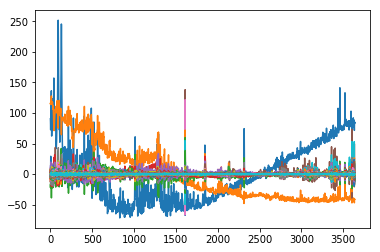

In [20]:
plt.plot(PC)
plt.show()

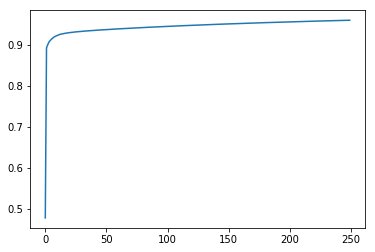

In [21]:
evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()
plt.plot(evals_cs)
plt.show()

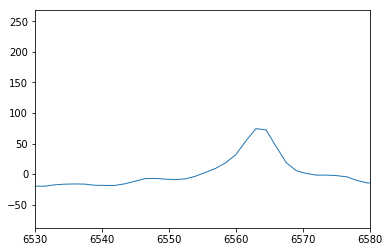

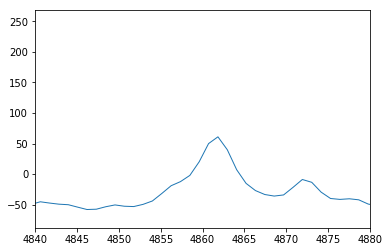

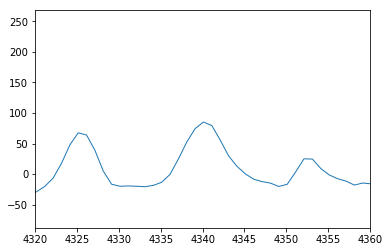

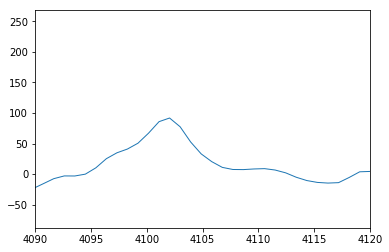

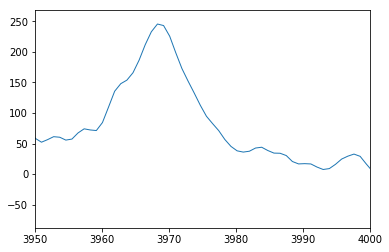

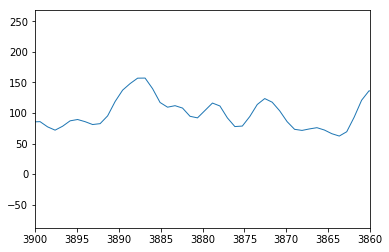

In [175]:
ranges = ((6530,6580), (4840,4880), (4320,4360), (4090,4120), (3950,4000),(3900,3860))

for i in range(0,6):
    plt.plot(10**(rangeinfimum+(np.arange(3640)*0.0001)), PCAwithtargets[0],'-', lw=1)
    plt.xlim(ranges[i])
    plt.show()

So the eigenvector[0] is providing us with the mean wavelength and we can see this from the balmer lines appearing in every situation. Then what are we getting from eigenvector[1], eigenvector[2], and so on..?

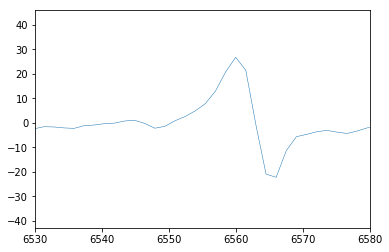

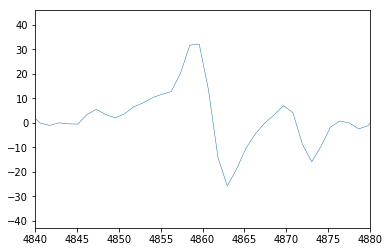

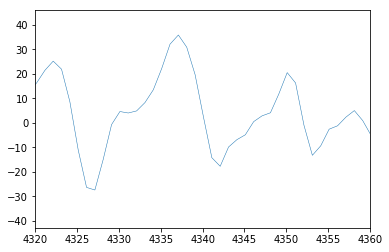

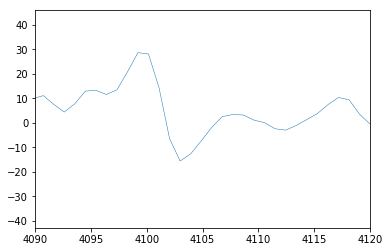

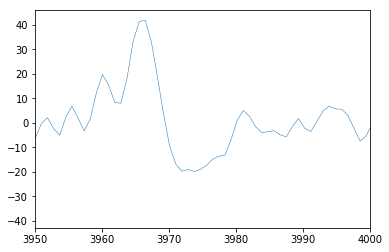

In [172]:
ranges = ((6530,6580), (4840,4880), (4320,4360), (4090,4120), (3950,4000))

for i in range(0,5):
    plt.plot(10**(rangeinfimum+(np.arange(3640)*0.0001)), PCAwithtargets[2],'-', lw=0.5)
    plt.xlim(ranges[i])
    plt.show()

## t-Student Distributed Neighbour Embedding

This might be able to be a section on outlier analysis. We should find out how others have spoken about their outliers, since it isn't worth holding onto.

In [46]:
from sklearn.manifold import TSNE
TsneTest = TSNE(n_components=2).fit_transform(tran.T)

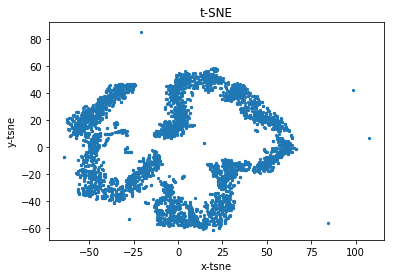

In [47]:
tSNEdata = pd.DataFrame(TsneTest,columns = ['x-tsne', 'y-tsne'])
tSNEdata.plot.scatter(x='x-tsne', y = 'y-tsne',marker = '.') #run this again
plt.title('t-SNE')
plt.show()

In [52]:
from sklearn.manifold import TSNE
TsneTest = TSNE(n_components=2).fit_transform(tran)

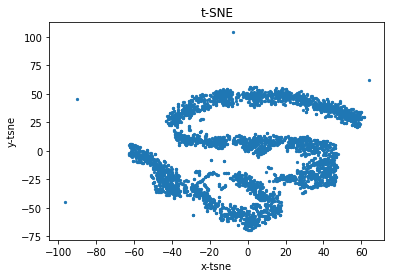

In [53]:
tSNEdata = pd.DataFrame(TsneTest,columns = ['x-tsne', 'y-tsne'])
tSNEdata.plot.scatter(x='x-tsne', y = 'y-tsne',marker = '.') #run this again
plt.title('t-SNE')
plt.show()

The orientation of the matrix doesn't seem to bother tsne.

## Density Based Spacial Clustering of Applications with Noise

According to paper lets see if we can go tsne -> DBSCAN -> tsne -> DBSCAN. Additionally, compare our results to HDBSCAN and see how that pans out. Might turn out to be more useful using HDBSCAN, also maybe that those outliers are hyper annoying, but it's hard to tell from this vantage point.

## Neural Network

In [145]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

np.random.seed(123)

In [160]:
from sklearn.model_selection import train_test_split                         #This is how to split to train our data!
train, test = train_test_split(tran.T, test_size=0.2)